## Part 4. Transfer Learning [8pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.



Notes on Transfer Learning. 

We first download the weights pretrained on the AlexNet dataset. 

```
alexnet_model = torchvision.models.alexnet(pretrained=True)    
```

To use it: 

1. First ensure that the images hve the right size. A ResNet-50 model expects a 224 x 224-pixel images (other models may expect other sizes, such as 299 x 299). 

We can use Kera's Resizing layer to resize two sample images (after cropping them to the target aspect ratio): 

``` 
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width-224, crop_to_aspect_ratio=True)(images)
```

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or from -1 to 1, and so on. Each model provides a preprocess_input() function that you can use to preprocess your images. these functions assume that the original pixel values range from 0 to 255. 

```
inputs = tf.keras.applications.resnet50.preprocess_inputs(images_resized)
```

Now you can use the pretrained model to make predictions: 

```
Y_proba = model.predict(inputs)
Y_proba.shape
```

As usual, the output Y_proba is a matrix wit one row per image and one column per clas. In this case, there are 1000 classes. 

**What image input size does the original model expect?**
**How can I ensure that the convolutional model on top of the current architecture doesn't alter the weights of the pretrained layers?**
We should freeze all the reuse layers first (i.e. make their weights non-trainable so that the gradient descent won't modify them and they will remain fied), then train your model and see how it performs. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights. 
If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. 

You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of droping them, and even adding more hidden layers. 



### Part (i) - [2pt EXPLORATORY] - Compute AlexNet Features and Save them
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

**Save the computed features**. You will be using these features as input to your neural network in Part
(ii), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

/Users/aordorica/opt/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Using mps device
Loading AlexNet pretrained model...
Image tensor shape: torch.Size([1, 3, 224, 224])
AlexNet loaded and feature extraction done for one image.
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([32, 256, 6, 6])
Features shape:  torch.Size([3

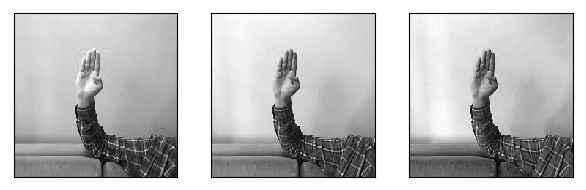

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

# Load AlexNet pretrained model
print("Loading AlexNet pretrained model...")
alexnet_model = models.alexnet(pretrained=True)
for param in alexnet_model.features.parameters():
    param.requires_grad = False  # Freeze the weights
alexnet_model.features.to(device)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label in os.listdir(root):
            label_path = os.path.join(root, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(label)
        self.le = preprocessing.LabelEncoder()
        self.labels = self.le.fit_transform(self.labels)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.image_paths)

# Function to compute features for a dataloader
def compute_features(dataloader, feature_extractor, device):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device).float()
            lbls = lbls.to(device)
            feat = feature_extractor(imgs)
            print("Features shape: ", feat.shape)
            features.append(feat.cpu())
            labels.append(lbls.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels)
    return features, labels

# Load a sample image and extract features
root = 'Lab_3b_Gesture_Dataset'
image_path = os.path.join(root, 'train/A/1_A_1.jpg')
raw_image = Image.open(image_path).convert('RGB')
img_tensor = transform(raw_image)
img_tensor = img_tensor.to(device).float()
img_tensor = img_tensor.unsqueeze(0)
features = alexnet_model.features(img_tensor)
print("Image tensor shape:", img_tensor.shape)
print("AlexNet loaded and feature extraction done for one image.")

# Create the datasets and dataloaders
datasets = {}
dataloaders = {}
for phase in ['train', 'val', 'test']:
    datasets[phase] = MyDataset(root=os.path.join(root, phase), transform=transform)
    dataloaders[phase] = DataLoader(datasets[phase], batch_size=32, shuffle=phase == 'train')

# Initialize the alexnet model with pretrained weights
feature_extractor = alexnet_model.features
feature_extractor.eval()

# Compute features and labels for all datasets
for phase in ['train', 'val', 'test']:
    features, labels = compute_features(dataloaders[phase], feature_extractor, device)
    features = features.to(torch.float32)
    torch.save(features, f'{phase}_features.pth')
    torch.save(labels, f'{phase}_labels.pth')

# Visualize the features
def visualize_features(dataloader):
    feature_maps = next(iter(dataloader))[0]
    plt.figure(figsize=(20, 20))
    for i in range(feature_maps.shape[1]):
        plt.subplot(8, 8, i + 1)  # Plotting 64 feature maps
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(feature_maps[0, i].detach().cpu().numpy(), cmap="gray")
    plt.show()

# Example usage:
visualize_features(dataloaders['train'])


In [4]:
# Make the features and labels compatible with sklearn  
train_features = torch.load('train_features.pth')
train_labels = torch.load('train_labels.pth')


train_features_np = train_features.view(len(train_features), -1).numpy()  
train_labels_np = train_labels.numpy()  
  
from sklearn.linear_model import LogisticRegression  
  
# Train the logistic regression model  
lr = LogisticRegression(max_iter=10000)  
lr.fit(train_features_np, train_labels_np)  
  
# Print accuracy  
train_acc = lr.score(train_features_np, train_labels_np)  
print(f"Training Accuracy: {train_acc * 100}%")  
  
# Note: You want to make sure to validate the model on a validation set that it hasn't seen before to make sure your model generalizes well.  

/Users/aordorica/opt/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/aordorica/opt/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

Training Accuracy: 100.0%


### Part (ii) - [2pt MODEL] - Build Conv Network on top of AlexNet Features
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [5]:
# Define the CNN model  
class MyCNN(nn.Module):  
    def __init__(self, input_channels, num_classes):  
        super(MyCNN, self).__init__()  
        # Convolutional layer (Sees 256x6x6 image tensor)  
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)  
        # Fully connected layer  
        self.fc = nn.Linear(16 * 6 * 6, num_classes) # Arguments (input, output)  
  
    def forward(self, x):  
        # Add sequence of convolutional and max pooling layers  
        x = F.relu(self.conv1(x))  
        x = x.view(-1, 16 * 6 * 6)  # flatten feature maps   
        x = self.fc(x)  
        return x  

    

**How many layers did you choose?**
I chose a simple architecture with two fully connected (linear) layers. 

> 1. Input Layer:
The input size is `256 * 6 * 6 = 9216`. This is because the precomputed AlexNet features for each image will be of this size.

> 2. First Fully Connected Layer (fc1):
> * Input size: 9216
> * Output size: 512

> This layer is followed by a ReLU activation function.

> 3. ReLU Activation Function (relu):
This adds non-linearity to the model, allowing it to learn complex mappings from inputs to outputs.

> 4. Second Fully Connected Layer (fc2):
> * Input size: 512
> * Output size: 9

> This layer is followed by a softmax activation function.

> 5. Softmax Activation Function (softmax):
This converts the output into a probability distribution over the 9 classes.

**What types of layers did you use: fully-connected or convolutional?**


> **Fully Connected vs. Convolutional Layers:**
Since we are using precomputed features from AlexNet, which has already learned spatial hierarchies and local patterns in the image through its convolutional layers, we do not need additional convolutional layers. The role of the neural network here is to learn the mapping from these high-level features to the classes. Hence, fully connected layers are used.


**What about other decisions like pooling layers, activation functions, number of channels / hidden units in each layer?**

> **Pooling Layers:**
Pooling layers are generally used to reduce the spatial dimensions of the input and to reduce the computational cost. However, since we are working with precomputed features and not raw images, there is no need for pooling layers.

> **Number of Hidden Units:**
The choice of 512 units in the first fully connected layer is somewhat arbitrary and can be tuned based on the performance of the model. The idea is to have a sufficient number of hidden units to learn the mapping from the input features to the output classes.

> **Activation Functions:**
ReLU is a common choice for activation functions because it introduces non-linearity while being computationally efficient. The softmax function at the output layer is used to convert the output into a probability distribution over the class



### Part (iii) - [1pt MODEL] - training the model
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.


### Part (iv) - [2pt RESULTS]
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(iv) without transfer learning?

Accuracy is 

Epoch 1/10, Loss: 0.4630, Accuracy: 85.77%
Epoch 2/10, Loss: 0.3331, Accuracy: 90.79%
Epoch 3/10, Loss: 0.2432, Accuracy: 92.05%
Epoch 4/10, Loss: 0.2432, Accuracy: 89.96%
Epoch 5/10, Loss: 0.1492, Accuracy: 94.98%
Epoch 6/10, Loss: 0.2318, Accuracy: 91.63%
Epoch 7/10, Loss: 0.2006, Accuracy: 92.47%
Epoch 8/10, Loss: 0.1615, Accuracy: 94.98%
Epoch 9/10, Loss: 0.1451, Accuracy: 94.98%
Epoch 10/10, Loss: 0.1887, Accuracy: 92.89%


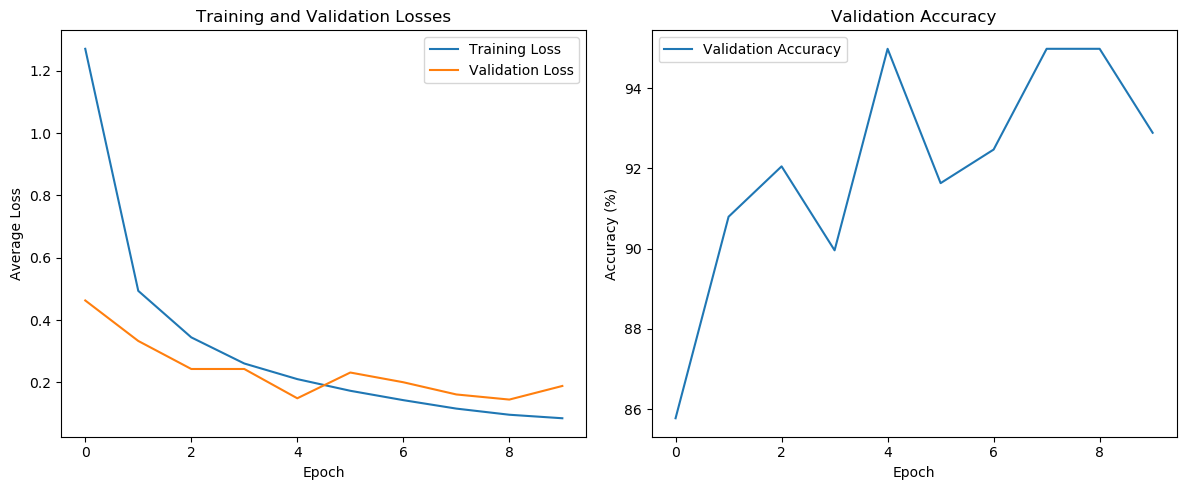

   Letter  Accuracy
0       0  0.973077
1       1  0.955556
2       2  0.988889
3       3  0.974074
4       4  0.762963
5       5  0.907407
6       6  0.800000
7       7  0.970370
8       8  0.958333


In [6]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import pandas as pd


# Load the precomputed features and labels  
train_features = torch.load('train_features.pth')  
train_labels = torch.load('train_labels.pth')  
validation_features = torch.load('validation_features.pth')  
validation_labels = torch.load('validation_labels.pth')  
  
# Convert the features and labels into TensorDatasets  
train_data = TensorDataset(train_features, train_labels)  
validation_data = TensorDataset(validation_features, validation_labels)  
  
# Convert the TensorDatasets into DataLoaders  
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)  

# Initialize the model, loss, optimizer, etc.
model = MyCNN(256, 9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10

# Lists to store losses and accuracies
train_losses = []
valid_losses = []
valid_accuracies = []
conf_matrix = None


# Training and validation loops
for epoch in range(num_epochs):  
    # Training loop
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update confusion matrix
            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu(), labels=range(9))
            else:
                conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=range(9))
            
            
            
    valid_loss /= len(validation_loader)
    accuracy = 100 * correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Plot training and validation losses and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
df = pd.DataFrame({'Letter': list(range(9)), 'Accuracy': class_accuracies})
print(df)

## Part 5. Testing on New Data [14pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted with your assignment. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

In [7]:
# Set the model to training mode
model.train()

# Number of epochs
n_epochs = 20

# List to store loss values
loss_values = []

for epoch in range(n_epochs):
    # Forward pass
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss values
    loss_values.append(loss.item())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


RuntimeError: Input type (torch.FloatTensor) and weight type (MPSFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
from sklearn import preprocessing

# Encode string labels to integers
label_encoder = preprocessing.LabelEncoder()
encoded_validation_labels = label_encoder.fit_transform(validation_labels)

# Convert the NumPy array of integers to a PyTorch tensor
validation_labels_tensor = torch.tensor(encoded_validation_labels)

# Set the model to evaluation mode
model.eval()

# Forward pass
val_outputs = model(validation_features)
_, predicted = torch.max(val_outputs.data, 1)
accuracy = (predicted == validation_labels_tensor).sum().item() / validation_labels_tensor.size(0)

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print("predicted shape: ", predicted.shape)
print("predicted dtype: ", predicted.dtype)
print("validation_labels_tensor shape: ", validation_labels_tensor.shape)
print("validation_labels_tensor dtype: ", validation_labels_tensor.dtype)



In [ ]:
from sklearn import preprocessing

# Encode string labels to integers
label_encoder = preprocessing.LabelEncoder()
encoded_test_labels = label_encoder.fit_transform(test_labels)

# Convert the NumPy array of integers to a PyTorch tensor
test_labels_tensor = torch.tensor(encoded_test_labels)

# Set the model to evaluation mode
model.eval()

# Forward pass
test_outputs = model(test_features)
_, predicted = torch.max(test_outputs.data, 1)
accuracy = (predicted == test_labels_tensor).sum().item() / test_labels_tensor.size(0)

print(f'Test Accuracy: {accuracy * 100:.2f}%')


## Part 5. Testing on New Data [14pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted with your assignment. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.



In [ ]:
# import os
# from PIL import Image
# import torch
# from torchvision import transforms

# # Set the device to GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load your trained model (assuming it's named 'model')
# model = model.to(device)
# model.eval()

# # Directory containing the images
# image_folder = 'resized_images/ordorica_1005592164'

# # List to store predictions
# predictions = []

# # Define the image transformations (resizing, normalization, etc.)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # Add any other necessary transformations
# ])

# # Load and process each image
# for filename in sorted(os.listdir(image_folder)):
#     if filename.endswith('.jpg'):
#         image_path = os.path.join(image_folder, filename)
        
#         # Load image
#         image = Image.open(image_path).convert('RGB')
        
#         # Preprocess image
#         image = transform(image)
        
#         # Add batch dimension and move to device
#         image = image.unsqueeze(0).to(device)
        
#         # Make prediction
#         with torch.no_grad():
#             output = model(image)
#             _, predicted_label = torch.max(output, 1)
        
#         # Decode prediction to string label (if necessary)
#         label = label_decoder(predicted_label.item())  # Define the label_decoder function based on your needs
        
#         predictions.append((filename, label))

# # Print predictions
# for filename, label in predictions:
#     print(f'{filename}: {label}')
